In [96]:
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import os
import pandas as pd
from torch.optim.lr_scheduler import StepLR

In [97]:
# Create a dummy dataset for illustration
class DummyDataset(Dataset):
    def __init__(self, input_size=10, num_samples=1000):
        self.input_size = input_size
        self.num_samples = num_samples
        
        # Generate random input data (features) and random target data (labels)
        self.data = torch.randn(self.num_samples, 1, self.input_size)  # Add an extra dimension for seq_len (1 in this case)
        self.targets = torch.randn(self.num_samples, 1)  # Output target (single value)
    
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

In [98]:
class BidirectionalRNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, pooling_type="max"):
        super(BidirectionalRNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Define the RNN layer with bidirectional option
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        
        # Define the pooling layer based on the specified pooling type
        if pooling_type == "max":
            self.pooling = nn.MaxPool1d(kernel_size=2, stride=2)  # Adjust kernel_size and stride
        elif pooling_type == "avg":
            self.pooling = nn.AvgPool1d(kernel_size=2, stride=2)  # Adjust kernel_size and stride
        
        # Define the fully connected output layer
        self.fc = nn.Linear(hidden_size * 2, output_size)  # Multiply by 2 for bidirectional
        
    def forward(self, x):
        # Get the RNN outputs
        out, _ = self.rnn(x)
        
        # Check the shape of the tensor before applying pooling
        print(f"Before pooling, tensor shape: {out.shape}")

        # Apply pooling (after flattening the output for pooling)
        out = out.permute(0, 2, 1)  # Change shape to (batch_size, channels, sequence_length)

        # Apply pooling only if the sequence length is large enough
        if out.size(2) > 1:  # Ensure the sequence length is greater than 1 for pooling to be valid
            out = self.pooling(out)     # Apply pooling
        else:
            print("Skipping pooling due to small sequence length")

        out = out.squeeze(2)        # Remove the sequence dimension after pooling
        
        # Pass through the fully connected layer
        out = self.fc(out)
        return out

In [99]:
# Hyperparameters
input_size = 10  # Example input size
hidden_sizes = [16, 32, 64]
num_layers = 2
output_size = 1
epochs_list = [5, 50, 100, 250, 350]
pooling_types = ['max', 'avg']
optimizers_list = ['sgd', 'rmsprop', 'adam']
learning_rate = 0.001
batch_size = 32

# Create a dummy dataset and dataloader
dataset = DummyDataset(input_size=input_size)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [100]:
# Initialize CSV file for combined results
combined_csv_path = "combined_bidirectional_training_results.csv"
if not os.path.exists(combined_csv_path):
    header = True
else:
    header = False

# Define function to save results to CSV
def save_results_to_csv(results, header=False):
    df = pd.DataFrame(results)
    df.to_csv(combined_csv_path, mode='a', header=header, index=False)

In [101]:
import numpy as np

class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience  # Number of epochs to wait for improvement
        self.delta = delta  # Minimum change to qualify as an improvement
        self.best_loss = np.inf  # Initialize with a large value
        self.counter = 0  # To track the number of epochs without improvement
        self.early_stop = False  # Flag to indicate if early stopping should be applied
        self.best_epoch = 0  # Store the epoch at which the best loss occurred

    def __call__(self, val_loss):
        # If the current loss is better than the best_loss, update best_loss and reset the counter
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_epoch = val_loss
        else:
            self.counter += 1

        # If counter exceeds patience, trigger early stopping
        if self.counter >= self.patience:
            self.early_stop = True


In [102]:
def train_model(model, dataloader, optimizer, criterion, epochs, scheduler, early_stopper, device):
    model.train()
    total_loss = 0
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)  # Move inputs and targets to the correct device
        optimizer.zero_grad()
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, targets)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update model weights
        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)  # Average loss over the dataset
    scheduler.step()  # Step the scheduler
    return avg_loss  # Return the average loss


In [103]:
# Create or load a CSV file to store the results
csv_file = 'experiment_BIRNN_results.csv'

# Function to save experiment results to CSV
def save_results_to_csv(hyperparameters, loss, csv_file):
    # Convert hyperparameters and loss into a dictionary for a single row
    result_dict = {**hyperparameters, 'loss': loss}
    
    # Check if the CSV file exists and write header only once
    if not os.path.isfile(csv_file):
        # If file doesn't exist, write header
        pd.DataFrame([result_dict]).to_csv(csv_file, index=False, mode='w', header=True)
    else:
        # If file exists, append results
        pd.DataFrame([result_dict]).to_csv(csv_file, index=False, mode='a', header=False)

In [104]:
# Experiment with different configurations
for hidden_size in hidden_sizes:
    for pooling_type in pooling_types:
        for optimizer_name in optimizers_list:
            for epochs in epochs_list:
                model = BidirectionalRNNModel(input_size, hidden_size, output_size, num_layers, pooling_type)
                model.to(device)
                criterion = torch.nn.MSELoss()

                # Select optimizer
                if optimizer_name == 'sgd':
                    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
                elif optimizer_name == 'rmsprop':
                    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
                elif optimizer_name == 'adam':
                    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

                # Learning rate scheduler
                scheduler = StepLR(optimizer, step_size=10, gamma=0.7)

                # Early stopping
                early_stopper = EarlyStopping(patience=5, delta=0.01)

                print(f"\nTraining with Hidden Size: {hidden_size}, Pooling: {pooling_type}, Optimizer: {optimizer_name}, Epochs: {epochs}")
                
                # Train the model and capture loss
                for epoch in range(epochs):
                    loss = train_model(model, dataloader, optimizer, criterion, epochs, scheduler, early_stopper, device)
                    
                    if loss is not None:  # Check if the loss is valid
                        hyperparameters = {
                            'hidden_size': hidden_size,
                            'pooling_type': pooling_type,
                            'optimizer': optimizer_name,
                            'epochs': epochs
                        }
                        save_results_to_csv(hyperparameters, loss, csv_file)

                        # Early stopping check
                        early_stopper(loss)
                        if early_stopper.early_stop:
                            print("Early stopping")
                            break



Training with Hidden Size: 16, Pooling: max, Optimizer: sgd, Epochs: 5
Before pooling, tensor shape: torch.Size([32, 1, 32])
Skipping pooling due to small sequence length
Before pooling, tensor shape: torch.Size([32, 1, 32])
Skipping pooling due to small sequence length
Before pooling, tensor shape: torch.Size([32, 1, 32])
Skipping pooling due to small sequence length
Before pooling, tensor shape: torch.Size([32, 1, 32])
Skipping pooling due to small sequence length
Before pooling, tensor shape: torch.Size([32, 1, 32])
Skipping pooling due to small sequence length
Before pooling, tensor shape: torch.Size([32, 1, 32])
Skipping pooling due to small sequence length
Before pooling, tensor shape: torch.Size([32, 1, 32])
Skipping pooling due to small sequence length
Before pooling, tensor shape: torch.Size([32, 1, 32])
Skipping pooling due to small sequence length
Before pooling, tensor shape: torch.Size([32, 1, 32])
Skipping pooling due to small sequence length
Before pooling, tensor shape

In [106]:
import pandas as pd

# Load the CSV file containing the results
csv_file = 'experiment_BIRNN_results.csv'
df = pd.read_csv(csv_file)

# Check the first few rows of the dataframe to verify the contents
df.head()
# Sort the dataframe by loss in ascending order (lowest loss first)
df_sorted = df.sort_values(by='loss').head(5)

# Display the top 5 rows
df_sorted


,hidden_size,pooling_type,optimizer,epochs,loss
244,16,avg,adam,100,0.906279
246,16,avg,adam,100,0.911512
243,16,avg,adam,100,0.912141
249,16,avg,adam,100,0.914086
247,16,avg,adam,100,0.915624


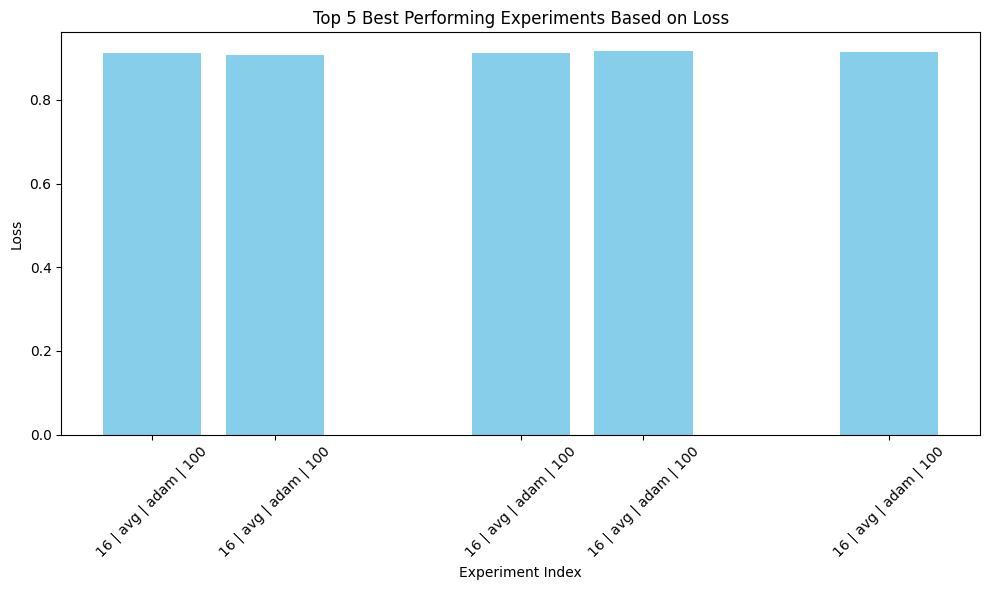

In [107]:
import matplotlib.pyplot as plt

# Plot the bar plot for the top 5 experiments
plt.figure(figsize=(10, 6))

# Create the bar plot
plt.bar(df_sorted.index, df_sorted['loss'], color='skyblue')

# Set labels and title
plt.xlabel('Experiment Index')
plt.ylabel('Loss')
plt.title('Top 5 Best Performing Experiments Based on Loss')

# Set x-axis tick labels for better readability
plt.xticks(df_sorted.index, df_sorted['hidden_size'].astype(str) + ' | ' + df_sorted['pooling_type'] + ' | ' + df_sorted['optimizer'] + ' | ' + df_sorted['epochs'].astype(str), rotation=45)

# Display the plot
plt.tight_layout()
plt.show()
